# Introducing custom actions

This hands-on workshop introduces the basic of custom actions and will teach you how to create your own actions to use in HOOMD. For more details, information that may be helpful when completing the exercises, see the [HOOMD-blue documentation](https://hoomd-blue.readthedocs.io/).

**FIRST:** Click the "Copy to Drive" button in the toolbar to save this notebook and any edits that you make to your Google Drive.

## Utility code

Please ignore the content of these cells, they provide some helpful methods but are not part of the workshop.

Run them one at a time, then click the arrow by "Utility code" to hide them.

In [ ]:
# This cell installs HOOMD in Google Colab. Delete it if you run locally
!pip install -q condacolab
import condacolab

condacolab.install_from_url(
    'https://github.com/glotzerlab/hoomd-workshop/releases/download/2022.0.1/hoomd-workshop-2022.0.1-Linux-x86_64.sh'
)

In [1]:
import math
from numbers import Number
import warnings

import fresnel
import freud
import gsd.hoomd
import hoomd
import IPython
import matplotlib
import numpy
import packaging.version

device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=400, h=400)

FRESNEL_MIN_VERSION = packaging.version.parse("0.13.0")
FRESNEL_MAX_VERSION = packaging.version.parse("0.14.0")


def render(simulation):
    if ('version' not in dir(fresnel) or packaging.version.parse(
            fresnel.version.version) < FRESNEL_MIN_VERSION
            or packaging.version.parse(
                fresnel.version.version) >= FRESNEL_MAX_VERSION):
        warnings.warn(
            f"Unsupported fresnel version {fresnel.version.version} - expect errors."
        )
    with simulation.state.cpu_local_snapshot as snapshot:
        L = snapshot.global_box.Lx
        scene = fresnel.Scene(device)
        geometry = fresnel.geometry.Sphere(scene,
                                           N=len(snapshot.particles.position),
                                           radius=0.5)
        geometry.material = fresnel.material.Material(color=fresnel.color.linear(
            [252 / 255, 209 / 255, 1 / 255]),
                                                      roughness=0.5)
        geometry.position[:] = snapshot.particles.position[:]
        geometry.outline_width = 0.04

        energies = snapshot.particles.net_energy
        mapper = matplotlib.cm.ScalarMappable(
            norm=matplotlib.colors.Normalize(vmin=numpy.min(energies),
                                             vmax=numpy.max(energies),
                                             clip=True),
            cmap=matplotlib.cm.get_cmap(name='viridis'))
        geometry.color[:] = fresnel.color.linear(mapper.to_rgba(energies))
        geometry.material.primitive_color_mix = 1

    box = fresnel.geometry.Box(scene, [L, L, L, 0, 0, 0], box_radius=.02)

    scene.lights = [
        fresnel.light.Light(direction=(0, 0, 1),
                            color=(0.8, 0.8, 0.8),
                            theta=math.pi),
        fresnel.light.Light(direction=(1, 1, 1),
                            color=(1.1, 1.1, 1.1),
                            theta=math.pi / 3)
    ]
    scene.camera = fresnel.camera.Orthographic(position=(L * 2, L, L * 2),
                                               look_at=(0, 0, 0),
                                               up=(0, 1, 0),
                                               height=L * 1.4 + 1)
    scene.background_color = (1, 1, 1)
    return IPython.display.Image(tracer.sample(scene, samples=20)._repr_png_())

## What are actions?

- Actions are objects that _act_ on a `hoomd.Simulation` object.
- Actions can be written in Python using `hoomd.custom.Action`.
- There are three categories of actions.
    - Updaters: modify simulation state
    - Writers: doesn't modify simulation state, writes out data
    - Tuners: doesn't modify simulation state, modifies object
      hyperparameters
      
We go ahead and create a simulation initialized with a single particle snapshot.

In [2]:
sim = hoomd.Simulation(hoomd.device.CPU())

# Create snapshot and initialize state
snap = hoomd.Snapshot()
snap.particles.N = 1
snap.particles.position[:] = [0, 0, 0]
snap.particles.types = ['A']
snap.particles.typeid[:] = [0]
snap.configuration.box = [10, 10, 10, 0, 0, 0]

sim.create_state_from_snapshot(snap)

## Initial custom action

Create a custom action as a subclass of
`hoomd.custom.Action`. Here we will create an action that prints
the timestep to standard out.

In [3]:
class PrintTimestep(hoomd.custom.Action):  # Note the inheritance

    def act(self, timestep):  # act always takes the timestep even if not used
        print(timestep)

We now have an action that can print out the simulation
timestep. The logic of the action goes inside the `act` method.

Let's go ahead and create a `PrintTimestep` object.

In [4]:
# Complete the code
# custom_action =

# Solution
custom_action = PrintTimestep()

## Using custom actions

To let an `Operations` object know what kind of action our
custom action is, we must wrap it in a subclass of
`hoomd.custom.CustomOperation`.
- `hoomd.write.CustomWriter`
- `hoomd.update.CustomUpdater` 
- `hoomd.tune.CustomTuner`

Create a `CustomWriter` operation that will call the custom action when triggered:

In [5]:
# Complete the code
# Hint: Look at the signature for CustomWriter
# custom_op = hoomd.write.CustomWriter(...)

# Solution
custom_op = hoomd.write.CustomWriter(action=custom_action,
                                     trigger=hoomd.trigger.Periodic(100))

Notice that custom operations take triggers like other operations.

Now we we must add `custom_op` to `sim.operations`.

In [6]:
# Code 

# Solution
sim.operations += custom_op

We can now run our simulation to see our custom action in work!

In [7]:
sim.run(1000)
sim.operations -= custom_op

100
200
300
400
500
600
700
800
900
1000


## Custom Action Features

### Accessing simulation state

By the time that a custom action will have its `act` method called
it will have an attribute `_state` accessible to it which is the
`Simulation.state` attribute.

In the cell below modify the class `CheckState` to print if the attribute `_state` exists
in the instance.

In [8]:
class CheckState(hoomd.custom.Action):

    def act(self, timestep):
        # Complete code
        # pass
        # Solution
        print(f"Has attribute _state: {hasattr(self, '_state')}")

Like in the previous section these are both writers. We will go ahead
and wrap them and see what happens when we try to run the simulation.

In [9]:
check_state = CheckState()
check_state_op = hoomd.write.CustomWriter(
    action=check_state, trigger=hoomd.trigger.Periodic(10))
sim.operations += check_state_op
sim.run(10)
sim.operations -= check_state_op

Has attribute _state: True


### Loggable Quantities in Custom Actions

Custom actions can use the logging subsystem through
the `hoomd.logging.log` decorator to document which methods/properties
of a custom action are loggable. By default the decorator makes the method
a property as well. (See documentation on 
`hoomd.logging.log` and `hoomd.logging.TypeFlags` for further information)

Below is an example which has a two loggables.

In [10]:
class ActionWithLoggables(hoomd.custom.Action):

    @hoomd.logging.log
    def scalar_property_loggable(self):
        return 42

    @hoomd.logging.log(category='string')
    def string_loggable(self):
        return "I am a string loggable."

    def act(self, timestep):
        pass


action = ActionWithLoggables()
display(action.scalar_property_loggable)
display(action.string_loggable)

42

'I am a string loggable.'

### Action attribute pass through

A custom action's attributes, methods, and properties are passed
through to the custom operation

In [11]:
custom_op = hoomd.write.CustomWriter(action=action, trigger=100)
custom_op.scalar_property_loggable

42

Below add a loggable `N_particles` that logs `State.N_particles`.

In [12]:
class LogNParticles(hoomd.custom.Action):
    # Complete code
    # pass
    # Solution
    @hoomd.logging.log
    def N_particles(self):
        return self._state.N_particles
    # End solution

## Creating a custom updater

Below we create a new simulation with a FCC lattice.

In [2]:
kT = 1.3

cpu = hoomd.device.CPU()
sim = hoomd.Simulation(device=cpu, seed=1)

box, positions = freud.data.UnitCell.fcc().generate_system(5, scale=1.6)
snap = hoomd.Snapshot()
snap.configuration.box = [box.Lx, box.Ly, box.Lz, 0.0, 0.0, 0.0]
snap.particles.N = len(positions)
snap.particles.position[:] = positions
snap.particles.types = ['A']
snap.particles.typeid[:] = 0

sim.create_state_from_snapshot(snap)

sim.state.thermalize_particle_momenta(filter=hoomd.filter.All(), kT=kT)

lj = hoomd.md.pair.LJ(nlist=hoomd.md.nlist.Cell(buffer=0.4))
lj.params[('A', 'A')] = {'epsilon': 1., 'sigma': 1.}
lj.r_cut[('A', 'A')] = 2.5
integrator = hoomd.md.Integrator(
    methods=[hoomd.md.methods.NVE(hoomd.filter.All())],
    forces=[lj], dt=0.005)

sim.operations += integrator

### Problem

In this section, we will show how to create a custom updater
that modifies the system state. To show this, we will create a custom
updater that adds a prescribed amount of energy to a single particle
simulating the bombardment of radioactive material into our system. For
this problem, we pick a random particle and modify its velocity
according to the radiation energy in a random direction.

In [3]:
class InsertEnergyUpdater(hoomd.custom.Action):

    def __init__(self, energy, seed=0):
        self.energy = energy
        self.rng = numpy.random.default_rng(seed)

    def act(self, timestep):
        snap = self._state.get_snapshot()
        if snap.communicator.rank == 0:
            direction = self._get_direction()
            particle_i = self.rng.integers(snap.particles.N)
            magnitude = self._get_magnitude(snap, particle_i)
            velocity = direction * magnitude
            snap.particles.velocity[particle_i] += velocity
        self._state.set_snapshot(snap)
        
    def _get_magnitude(self, snapshot, particle_index):
        """Get the velocity magnitude from mass and energy."""
        mass = snapshot.particles.mass[particle_index]
        return numpy.sqrt(2 * self.energy / mass)

    def _get_direction(self):
        """Get a random vector on the unit sphere."""
        theta, z = self.rng.random(2)
        theta *= 2 * numpy.pi
        z = 2 * (z - 0.5)
        return numpy.array([
            numpy.sqrt(1 - (z * z)) * numpy.cos(theta),
            numpy.sqrt(1 - (z * z)) * numpy.sin(theta), z
        ])

We will log a few thermodynamic quantities to observe our new custom action.

In [4]:
thermo = hoomd.md.compute.ThermodynamicQuantities(hoomd.filter.All())
logger = hoomd.logging.Logger(categories=['scalar'])
logger.add(thermo, ['kinetic_energy', 'potential_energy'])
logger['total_energy'] = (
    lambda: thermo.kinetic_energy + thermo.potential_energy, 'scalar')

table = hoomd.write.Table(100, logger, max_header_len=1)

sim.operations += thermo
sim.operations += table

Now create and add a `InsertEnergyUpdater` to the simultion.

In [5]:
# Code
# Solution
energy_operation = hoomd.update.CustomUpdater(action=InsertEnergyUpdater(100.),
                                              trigger=1_000)

sim.operations += energy_operation

In [6]:
sim.run(5_000)
sim.operations.updaters.clear()

 kinetic_energy  potential_energy   total_energy  
   545.75227       -3375.79080      -2830.03852   
   533.10922       -3361.81952      -2828.71030   
   538.65455       -3367.27631      -2828.62176   
   543.93471       -3373.51919      -2829.58448   
   543.92939       -3372.99396      -2829.06457   
   543.24485       -3371.66704      -2828.42218   
   582.61109       -3412.20808      -2829.59699   
   568.85464       -3397.58639      -2828.73175   
   554.11251       -3383.39833      -2829.28581   
   559.86185       -3388.84152      -2828.97968   
   603.21512       -3342.32683      -2739.11170   
   603.14123       -3343.04894      -2739.90771   
   590.75225       -3331.04094      -2740.28869   
   594.68874       -3334.22524      -2739.53649   
   584.95331       -3324.26068      -2739.30737   
   603.09216       -3342.38526      -2739.29310   
   613.09807       -3352.58789      -2739.48982   
   595.35496       -3334.77828      -2739.42332   
   603.87102       -3343.70271 

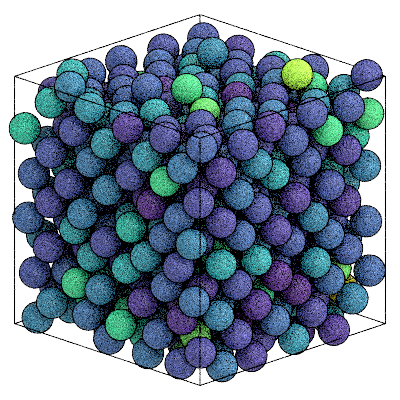

In [7]:
render(sim)

As we can see the total energy of the system is indeed increasing.
The energy isn't increasing by the same amount every time since we
are adding the velocity in a random direction which may be against
the current velocity.

### Improving upon our Custom Action

Maybe we want to allow for the energy to be from a distribution.
HOOMD-blue has a concept called a variant which allows for quantities
that vary over time.

<div class="alert alert-warning" style="color: black;">
    <h4>Note:</h4>
    <p><code>Variant</code> objects model a parameter as a 
        function of the timestep, so to get the value for a particular
        timestep we have to <strong>call</strong> the variant. For more
        information see the documentation for 
        <code>hoomd.variant</code>.
    </p>
</div>

Below modify the `InsertEnergyUpdater` class to accept a variant for
energy.

In [8]:
# Modify code below 
# Hint look at everywhere energy is used.
class InsertEnergyUpdater(hoomd.custom.Action):

    def __init__(self, energy, seed=0):
        self.energy = energy
        self.rng = numpy.random.default_rng(seed)

    def act(self, timestep):
        snap = self._state.get_snapshot()
        if snap.communicator.rank == 0:
            direction = self._get_direction()
            particle_i = self.rng.integers(snap.particles.N)
            magnitude = self._get_magnitude(
                snap, self.energy(timestep), particle_i)
            velocity = direction * magnitude
            snap.particles.velocity[particle_i] += velocity
        self._state.set_snapshot(snap)
        
    def _get_magnitude(self, snapshot, energy, particle_index):
        """Get the velocity magnitude from mass and energy."""
        mass = snapshot.particles.mass[particle_index]
        return numpy.sqrt(2 * energy / mass)

    def _get_direction(self):
        """Get a random vector on the unit sphere."""
        theta, z = self.rng.random(2)
        theta *= 2 * numpy.pi
        z = 2 * (z - 0.5)
        return numpy.array([
            numpy.sqrt(1 - (z * z)) * numpy.cos(theta),
            numpy.sqrt(1 - (z * z)) * numpy.sin(theta), z
        ])

Now
- Create an updated `InsertEnergyUpdater` with a
  `hoomd.variant.Ramp` variant that starts at 1 and goes to 20
  that starts at the current timestep and takes 1,000 timesteps,
  and triggers every 251 steps.
- Add the action to the simulation
- run the simulation for 1,001 steps.

In [9]:
# Create and add our custom updater
# Code
# Solution
energy = hoomd.variant.Ramp(
    1.0, 20.0, sim.timestep, 1_000)
energy_operation = hoomd.update.CustomUpdater(
    action=InsertEnergyUpdater(energy), trigger=251)
sim.operations += energy_operation
sim.run(1_001)
# End solution
sim.operations.updaters.clear()
sim.operations.writers.clear()

   781.68857       -3203.32367      -2421.63510   
   788.18102       -3210.73054      -2422.54952   
   782.13081       -3194.00267      -2411.87187   
   794.70922       -3206.22491      -2411.51570   
   778.02154       -3189.09574      -2411.07419   
   798.94110       -3202.07358      -2403.13249   
   779.69873       -3183.20658      -2403.50785   
   803.77308       -3194.69249      -2390.91941   
   806.59861       -3197.67236      -2391.07376   
   839.53164       -3230.76907      -2391.23743   


## Performance

### General performance tips

* Use local snapshots
* Store property values from `hoomd` objects (e.g. `hoomd.md.pair.LJ.energy`)
  if used multiple times.
* Use NumPy and CuPy broadcasting over for loops.

The cell below shows the usage of the `cpu_local_snapshot`.
When running on GPUs a `gpu_local_snapshot` is available as well.

In [11]:
with sim.state.cpu_local_snapshot as snap:
    print(snap.particles.position[:5])
    print(snap.particles.tag[:5])
    print(snap.particles.rtag[:5])

HOOMDArray([[-3.71929407 -3.95491682 -3.0095085 ]
 [-3.62473749 -3.30897378 -3.79327208]
 [-2.02635122 -3.28522878 -3.76679292]
 [-2.75891138 -3.28852707 -2.96923841]
 [-2.0827378  -3.38338345 -2.12962387]])
HOOMDArray([344 473 498 225 499])
HOOMDArray([455 385 111  43 388])


### Measure original actions' performance

In [ ]:
energy_action = InsertEnergyUpdater(hoomd.variant.Constant(1))
energy_operation = hoomd.update.CustomUpdater(action=energy_action, trigger=1)
sim.operations.updaters.append(energy_operation)

In [ ]:
%%timeit
sim.run(100)

383 ms ± 17.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Use local snapshot in updater

We will now optimize the code to use
the `cpu_local_snapshot` for updating velocities.
Below switch `act` to use `cpu_local_snapshot`.

In [ ]:
class InsertEnergyUpdater(hoomd.custom.Action):

    def __init__(self, energy, seed=0):
        self.energy = energy
        self.rng = numpy.random.default_rng(seed)

    def act(self, timestep):
        direction = self._get_direction()
        energy = self.energy(timestep)
        particle_i = self.rng.integers(self._state.N_particles)
        # Code
        with self._state.cpu_local_snapshot as snap:
            # Solution
            # This code does not work with MPI
            i = snap.particles.rtag[particle_i]
            magnitude = self._get_magnitude(snap, energy, i)
            velocity = direction * magnitude
            snap.particles.velocity[i] += velocity
        
    def _get_magnitude(self, snapshot, energy, particle_index):
        """Get the velocity magnitude from mass and energy."""
        mass = snapshot.particles.mass[particle_index]
        return numpy.sqrt(2 * energy / mass)

    def _get_direction(self):
        """Get a random vector on the unit sphere."""
        theta, z = self.rng.random(2)
        theta *= 2 * numpy.pi
        z = 2 * (z - 0.5)
        return numpy.array([
            numpy.sqrt(1 - (z * z)) * numpy.cos(theta),
            numpy.sqrt(1 - (z * z)) * numpy.sin(theta), z
        ])

### Measure new actions' performance

In [26]:
# Create and add our modified custom updater
sim.operations -= energy_operation
energy_action = InsertEnergyUpdater(hoomd.variant.Constant(1))
energy_operation = hoomd.update.CustomUpdater(action=energy_action, trigger=1)
sim.operations.updaters.append(energy_operation)

In [27]:
%%timeit
sim.run(100)

126 ms ± 1.96 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
